# add header

In [1]:
import pandas as pd

# Read the .out file
df = pd.read_csv("20170101.csv.out", header=None, delimiter=",")  # header=None treats first row as data

# Define the column names
columns = ["vehicle_id", "gpsvalid", "lat", "lon", "timestamp", "speed", "heading", "for_hire_light", "engine_acc"]

# Assign the column names to the dataframe
df.columns = columns

# Save as a proper CSV with header
df.to_csv("taxi.csv", index=False)

print("File converted to taxi.csv with header")


File converted to taxi.csv with header


# cleaning part

In [4]:
import pandas as pd

df = pd.read_csv("vehicle_data_clean.csv")

# Step 1: Group and filter
dup_all_zero = (
    df.groupby("vehicle_id")
      .agg(
          count_rows=("speed", "count"),   # use count instead of size
          all_zero=("speed", lambda x: (x == 0).all())
      )
)

dup_all_zero = dup_all_zero[(dup_all_zero["all_zero"]) & (dup_all_zero["count_rows"] > 1)]

# Step 2: Save vehicles that always had speed 0
dup_all_zero.to_csv("all_speed_is_0.csv")

# Step 3: Drop rows in df where vehicle_id is in broke_car list
df = df[~df["vehicle_id"].isin(dup_all_zero.index)]

# Step 4: Overwrite original file (permanent)
df.to_csv("vehicle_data_clean.csv", index=False)

print(f"Removed {len(dup_all_zero)} vehicles. Cleaned file saved as vehicle_data_clean.csv with {len(df)} rows.")


Removed 0 vehicles. Cleaned file saved as vehicle_data_clean.csv with 2387620 rows.


In [2]:
import pandas as pd

# Step 1: Load your CSV
df = pd.read_csv("vehicle_data_clean.csv")

# Step 2: Identify vehicles that never got a customer
# for_hire_light = 1 means the taxi had no passenger (for hire), 
# so we check if it ever switched to 1 -> 0 (got a customer)
vehicles_never_hired = df.groupby("vehicle_id")["for_hire_light"].max()
vehicles_never_hired = vehicles_never_hired[vehicles_never_hired == 0].index.tolist()

print("Vehicles that never got any customer:", len(vehicles_never_hired))
# Step 3: Remove these vehicles from the dataframe
df_filtered = df[~df["vehicle_id"].isin(vehicles_never_hired)]
print("how manu row left",len(df_filtered))
# Step 4: Save the filtered dataframe to a new CSV
df_filtered.to_csv("vehicle_data_clean.csv", index=False)

print(f"Filtered CSV saved as 'vehicle_data_filtered.csv' with {len(df_filtered)} rows.")


Vehicles that never got any customer: 0
how manu row left 2030108
Filtered CSV saved as 'vehicle_data_filtered.csv' with 2030108 rows.


In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("vehicle_data_clean.csv")

# Step 1: Check NaN counts
print("NaN counts per column before dropping:")
print(df.isna().sum())
print("\nTotal NaN values before dropping:", df.isna().sum().sum())

# Step 2: Drop all rows that contain any NaN
df_clean = df.dropna()

# Step 3: Check again after cleaning
print("\nNaN counts per column after dropping:")
print(df_clean.isna().sum())
print("\nTotal NaN values after dropping:", df_clean.isna().sum().sum())

# (Optional) Save cleaned dataset
df_clean.to_csv("vehicle_data_clean.csv", index=False)

NaN counts per column before dropping:
vehicle_id        0
gpsvalid          0
lat               0
lon               0
timestamp         0
speed             0
heading           0
for_hire_light    0
engine_acc        0
dtype: int64

Total NaN values before dropping: 0

NaN counts per column after dropping:
vehicle_id        0
gpsvalid          0
lat               0
lon               0
timestamp         0
speed             0
heading           0
for_hire_light    0
engine_acc        0
dtype: int64

Total NaN values after dropping: 0


In [4]:
# Remove rows where speed > 300
df = df[df["speed"] <= 300].reset_index(drop=True)

# Save cleaned dataset to a new CSV
df.to_csv("vehicle_data_clean.csv", index=False)

# feature engineer part build training set

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load dataset (assuming df is already loaded with columns: vehicle_id, timestamp, for_hire_light, lat, lon, speed, heading)
# df should have columns: vehicle_id, timestamp, for_hire_light, lat, lon, speed, heading

# Ensure proper timestamp ordering
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["vehicle_id", "timestamp"])

# Shift to detect transitions
df["prev_light"] = df.groupby("vehicle_id")["for_hire_light"].shift(1)

# Identify pickups (1 -> 0) and dropoffs (0 -> 1)
pickups = df[(df["prev_light"] == 1) & (df["for_hire_light"] == 0)].copy()
dropoffs = df[(df["prev_light"] == 0) & (df["for_hire_light"] == 1)].copy()

# Match pickup with the *next* dropoff for the same vehicle
pickups["dropoff_lat"] = np.nan
pickups["dropoff_lon"] = np.nan

for vid in pickups["vehicle_id"].unique():
    p_idx = pickups[pickups["vehicle_id"] == vid].index
    d_idx = dropoffs[dropoffs["vehicle_id"] == vid].index

    # Pair them sequentially
    for pi, di in zip(p_idx, d_idx):
        pickups.loc[pi, "dropoff_lat"] = df.loc[di, "lat"]
        pickups.loc[pi, "dropoff_lon"] = df.loc[di, "lon"]

# Drop rows where dropoff coordinates are missing (if any)
pickups = pickups.dropna(subset=["dropoff_lat", "dropoff_lon"])

# Add heading features (sin and cos of heading in radians)
pickups["sin_heading"] = np.sin(np.radians(pickups["heading"]))
pickups["cos_heading"] = np.cos(np.radians(pickups["heading"]))

# --- KMeans Clustering for Drop-off Zones ---
# Prepare drop-off coordinates for clustering
dropoff_coords = pickups[["dropoff_lat", "dropoff_lon"]].values

# Apply KMeans clustering (choose number of clusters, e.g., 50)
n_clusters = 50  # Adjust based on your dataset size and desired granularity
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pickups["kmeans_zone"] = kmeans.fit_predict(dropoff_coords)

# --- Grid-Based Zoning for Drop-off Points ---
# Define grid size (e.g., 0.01 degrees ~ 1 km depending on location)
grid_size = 0.01

# Create grid cell IDs
pickups["grid_zone"] = (
    (pickups["dropoff_lat"] // grid_size).astype(int) * 1000 + 
    (pickups["dropoff_lon"] // grid_size).astype(int)
)

# Build final training dataset
training = pd.DataFrame({
    "vehicle_id": pickups["vehicle_id"].astype(str),
    "pickup_time": pickups["timestamp"].dt.strftime("%Y-%m-%d %H:%M:%S"),
    "pickup_lat": pickups["lat"].astype(float),
    "pickup_lon": pickups["lon"].astype(float),
    "sin_hour": np.sin(2 * np.pi * pickups["timestamp"].dt.hour / 24),
    "cos_hour": np.cos(2 * np.pi * pickups["timestamp"].dt.hour / 24),
    "pickup_speed": pickups["speed"].astype(float),
    "sin_heading": pickups["sin_heading"].astype(float),  # New heading feature
    "cos_heading": pickups["cos_heading"].astype(float),  # New heading feature
    "kmeans_zone": pickups["kmeans_zone"].astype(int),    # KMeans cluster ID as label
    "grid_zone": pickups["grid_zone"].astype(int),        # Grid cell ID as label
    "dropoff_lat": pickups["dropoff_lat"].astype(float),
    "dropoff_lon": pickups["dropoff_lon"].astype(float),
})

# Save to CSV
training.to_csv("training_rides_with_zones_and_heading.csv", index=False)

print("✅ Training dataset with vehicle_id, pickup_time, kmeans_zone, grid_zone, sin_heading, and cos_heading saved as training_rides_with_zones_and_heading.csv")


✅ Training dataset with vehicle_id, pickup_time, kmeans_zone, grid_zone, sin_heading, and cos_heading saved as training_rides_with_zones_and_heading.csv


# model radom forest regression

Mean Squared Error (MSE): 0.000771
R-squared (R²): 0.990240
Cross-Validated MSE: 0.000751
Average Haversine Error (km): 1.54
Saved predictions with vehicle IDs to predicted_dropoffs.csv


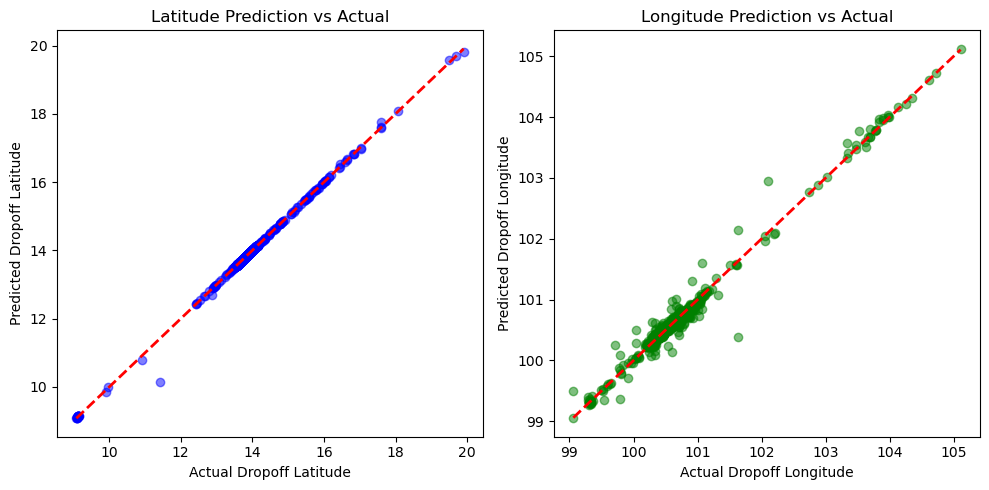

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# Load the cleaned CSV
df = pd.read_csv('training_rides_with_zones_and_heading.csv')

# Features (X) including heading + zone
X = df[['pickup_lat', 'pickup_lon', 'sin_hour', 'cos_hour', 'pickup_speed',
        'sin_heading', 'cos_heading', 'kmeans_zone', 'grid_zone']]
# Targets (y)
y = df[['dropoff_lat', 'dropoff_lon']]
# Vehicle IDs
vehicle_ids = df['vehicle_id']

# Split data (keep vehicle_id aligned)
X_train, X_test, y_train, y_test, veh_train, veh_test = train_test_split(
    X, y, vehicle_ids, test_size=0.2, random_state=42
)

# Scale features (optional for RF)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RF model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputRegressor(rf)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.6f}')
print(f'R-squared (R²): {r2:.6f}')

# Cross-validation (per target, average)
cv_mse_list = []
for i in range(y_train.shape[1]):
    scores = cross_val_score(rf, X_train_scaled, y_train.iloc[:, i], cv=5,
                             scoring='neg_mean_squared_error')
    cv_mse_list.append(-scores.mean())
cv_mse = np.mean(cv_mse_list)
print(f'Cross-Validated MSE: {cv_mse:.6f}')

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Compute Haversine error for each prediction
haversine_errors = [haversine(y_test.iloc[i, 0], y_test.iloc[i, 1],
                              y_pred[i, 0], y_pred[i, 1])
                    for i in range(len(y_test))]
avg_haversine_error = np.mean(haversine_errors)
print(f'Average Haversine Error (km): {avg_haversine_error:.2f}')

# Build prediction DataFrame with vehicle_id
pred_df = pd.DataFrame({
    "vehicle_id": veh_test.values,
    "pickup_lat": X_test['pickup_lat'].values,
    "pickup_lon": X_test['pickup_lon'].values,
    "pred_drop_lat": y_pred[:, 0],
    "pred_drop_lon": y_pred[:, 1],
    "true_drop_lat": y_test['dropoff_lat'].values,
    "true_drop_lon": y_test['dropoff_lon'].values,
    "haversine_error_km": haversine_errors
})

# Save to CSV
pred_df.to_csv("predicted_dropoffs.csv", index=False)
print("Saved predictions with vehicle IDs to predicted_dropoffs.csv")

# Visualization
plt.figure(figsize=(10, 5))

# Latitude plot
plt.subplot(1, 2, 1)
plt.scatter(y_test['dropoff_lat'], y_pred[:, 0], color='blue', alpha=0.5)
plt.plot([y_test['dropoff_lat'].min(), y_test['dropoff_lat'].max()],
         [y_test['dropoff_lat'].min(), y_test['dropoff_lat'].max()], 'r--', lw=2)
plt.xlabel('Actual Dropoff Latitude')
plt.ylabel('Predicted Dropoff Latitude')
plt.title('Latitude Prediction vs Actual')

# Longitude plot
plt.subplot(1, 2, 2)
plt.scatter(y_test['dropoff_lon'], y_pred[:, 1], color='green', alpha=0.5)
plt.plot([y_test['dropoff_lon'].min(), y_test['dropoff_lon'].max()],
         [y_test['dropoff_lon'].min(), y_test['dropoff_lon'].max()], 'r--', lw=2)
plt.xlabel('Actual Dropoff Longitude')
plt.ylabel('Predicted Dropoff Longitude')
plt.title('Longitude Prediction vs Actual')

plt.tight_layout()
plt.show()


# HDBSCAN

In [1]:
import pandas as pd
import numpy as np
import hdbscan
from math import radians, cos, sin, asin, sqrt

# --------------------------
# Helper: Haversine distance (km)
# --------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# --------------------------
# Run HDBSCAN clustering
# --------------------------
def run_hdbscan(coords, min_cluster_size=10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='haversine')
    labels = clusterer.fit_predict(np.radians(coords))  # HDBSCAN expects radians for haversine
    return labels

# --------------------------
# Limit clusters to max_n
# --------------------------
def limit_clusters(coords, labels, max_n=200):
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels

    cluster_sizes = df['label'].value_counts().to_dict()
    unique_clusters = [c for c in cluster_sizes.keys() if c != -1]
    sorted_clusters = sorted(unique_clusters, key=lambda x: cluster_sizes[x], reverse=True)

    keep_clusters = sorted_clusters[:max_n]

    new_labels = []
    for lab in labels:
        if lab in keep_clusters or lab == -1:
            new_labels.append(lab)
        else:
            new_labels.append(-1)
    return np.array(new_labels)

# --------------------------
# Compute cluster centroids and radius
# --------------------------
def cluster_stats(coords, labels):
    clusters = {}
    df = pd.DataFrame(coords, columns=['lat','lon'])
    df['label'] = labels
    for label in set(labels):
        if label == -1:
            continue
        points = df[df['label'] == label][['lat','lon']].values
        center = points.mean(axis=0)
        radius = max([haversine(center[0], center[1], p[0], p[1]) for p in points]) if len(points) > 0 else 0

        clusters[label] = {
            'center_lat': center[0],
            'center_lon': center[1],
            'radius_km': radius,
            'name': f"Cluster_{label}"
        }
    return clusters

# --------------------------
# Merge close clusters (airport fix)
# --------------------------
def merge_close_clusters(coords, labels, clusters, max_distance_km=1.5):
    new_labels = labels.copy()
    cluster_ids = list(clusters.keys())
    for i in range(len(cluster_ids)):
        for j in range(i+1, len(cluster_ids)):
            ci, cj = cluster_ids[i], cluster_ids[j]
            c1, c2 = clusters[ci], clusters[cj]
            d = haversine(c1['center_lat'], c1['center_lon'], c2['center_lat'], c2['center_lon'])
            if d <= max_distance_km:
                main_id = min(ci, cj)
                merge_id = max(ci, cj)
                new_labels = np.where(new_labels == merge_id, main_id, new_labels)
    return new_labels

# --------------------------
# Build long-format flow matrix
# --------------------------
def build_flow_matrix(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters):
    df = pd.DataFrame({'pickup': pickup_labels, 'dropoff': drop_labels})
    flow_counts = df.groupby(['pickup','dropoff']).size().reset_index(name='count')
    total_counts = flow_counts.groupby('pickup')['count'].transform('sum')
    flow_counts['probability'] = (flow_counts['count'] / total_counts) * 100

    rows = []
    for _, row in flow_counts.iterrows():
        p, d, prob = row['pickup'], row['dropoff'], row['probability']
        if p == -1 or d == -1:
            continue
        rows.append({
            'pickup_zone': p,
            'pickup_name': pickup_clusters[p]['name'],
            'pickup_center_lat': pickup_clusters[p]['center_lat'],
            'pickup_center_lon': pickup_clusters[p]['center_lon'],
            'pickup_radius_km': pickup_clusters[p]['radius_km'],
            'dropoff_zone': d,
            'dropoff_name': drop_clusters[d]['name'],
            'dropoff_center_lat': drop_clusters[d]['center_lat'],
            'dropoff_center_lon': drop_clusters[d]['center_lon'],
            'dropoff_radius_km': drop_clusters[d]['radius_km'],
            'probability_%': round(prob,2)
        })
    return pd.DataFrame(rows)

# --------------------------
# --- Main ---
# --------------------------
data = pd.read_csv("predicted_dropoffs.csv")

# Jitter to avoid duplicates
data['pickup_lat_jitter'] = data['pickup_lat'] + np.random.uniform(-1e-5,1e-5,len(data))
data['pickup_lon_jitter'] = data['pickup_lon'] + np.random.uniform(-1e-5,1e-5,len(data))
data['drop_lat_jitter'] = data['pred_drop_lat'] + np.random.uniform(-1e-5,1e-5,len(data))
data['drop_lon_jitter'] = data['pred_drop_lon'] + np.random.uniform(-1e-5,1e-5,len(data))

# --- Run clustering ---
pickup_labels_raw = run_hdbscan(data[['pickup_lat_jitter','pickup_lon_jitter']].values, min_cluster_size=5)
pickup_labels = limit_clusters(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels_raw, max_n=1000)

drop_labels_raw = run_hdbscan(data[['drop_lat_jitter','drop_lon_jitter']].values, min_cluster_size=5)
drop_labels = limit_clusters(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels_raw, max_n=1000)

# --- Compute cluster centroids and radii ---
pickup_clusters = cluster_stats(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels)
drop_clusters = cluster_stats(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels)

# --- Merge close clusters (fix for airport) ---
pickup_labels = merge_close_clusters(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels, pickup_clusters, max_distance_km=1.5)
drop_labels = merge_close_clusters(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels, drop_clusters, max_distance_km=1.5)

# --- Recompute clusters after merging ---
pickup_clusters = cluster_stats(data[['pickup_lat_jitter','pickup_lon_jitter']].values, pickup_labels)
drop_clusters = cluster_stats(data[['drop_lat_jitter','drop_lon_jitter']].values, drop_labels)

# --- Print cluster counts ---
print(f"Number of pickup clusters (excl. noise): {len(pickup_clusters)}")
print(f"Number of dropoff clusters (excl. noise): {len(drop_clusters)}")

# --- Build flow matrix ---
flow_df = build_flow_matrix(data, pickup_labels, drop_labels, pickup_clusters, drop_clusters)

# --- Save ---
flow_df.to_csv("pickup_dropoff_flows.csv", index=False)
print("Flow CSV saved as pickup_dropoff_flows.csv")
print(flow_df.head())

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of pickup clusters (excl. noise): 216
Number of dropoff clusters (excl. noise): 187
Flow CSV saved as pickup_dropoff_flows.csv
   pickup_zone pickup_name  pickup_center_lat  pickup_center_lon  \
0          0.0   Cluster_0           9.225355          99.276286   
1          1.0   Cluster_1          15.745389         103.634635   
2          4.0   Cluster_4          12.967805         100.930003   
3          5.0   Cluster_5          13.270983         100.944914   
4          9.0   Cluster_9          13.541779         100.235681   

   pickup_radius_km  dropoff_zone dropoff_name  dropoff_center_lat  \
0        142.502299           0.0    Cluster_0            9.310738   
1        144.633736           1.0    Cluster_1           15.790822   
2         12.239948           3.0    Cluster_3           12.977963   
3         10.542645           3.0    Cluster_3           12.977963   
4          2.047397           7.0    Cluster_7           13.556550   

   dropoff_center_lon  dropoff_radiu